In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, DateType, DoubleType, ArrayType
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.window import Window

In [2]:
spark = SparkSession.builder.appName("StockDataCleaning") \
    .config("spark.executor.memory", "4g").getOrCreate()

23/11/13 17:06:59 WARN Utils: Your hostname, michaelwoan-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/11/13 17:06:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/13 17:06:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
schema = StructType([ \
    StructField("date", DateType(), True), \
    StructField("low", FloatType(), True), \
    StructField("open", FloatType(), True), \
    StructField("high", FloatType(), True), \
    StructField("volume", IntegerType(), True), \
    StructField("close", FloatType(), True)])

In [4]:
stockData = spark.read.schema(schema).csv("./stocks-data/MSFT.csv", header=True)

In [5]:
stockData.printSchema()

root
 |-- date: date (nullable = true)
 |-- low: float (nullable = true)
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- volume: integer (nullable = true)
 |-- close: float (nullable = true)



In [6]:
stockData.show()

+----------+--------+--------+--------+----------+--------+
|      date|     low|    open|    high|    volume|   close|
+----------+--------+--------+--------+----------+--------+
|1986-03-13|0.088542|0.088542|0.101563|1031788800|0.097222|
|1986-03-13|0.088542|0.088542|0.101563|1031788800|0.097222|
|1986-03-13|0.088542|0.088542|0.101563|1031788800|0.097222|
|1986-03-14|0.097222|0.097222|0.102431| 308160000|0.100694|
|1986-03-14|0.097222|0.097222|0.102431| 308160000|0.100694|
|1986-03-14|0.097222|0.097222|0.102431| 308160000|0.100694|
|1986-03-17|0.100694|0.100694|0.103299| 133171200|0.102431|
|1986-03-17|0.100694|0.100694|0.103299| 133171200|0.102431|
|1986-03-17|0.100694|0.100694|0.103299| 133171200|0.102431|
|1986-03-18|0.098958|0.102431|0.103299|  67766400|0.099826|
|1986-03-18|0.098958|0.102431|0.103299|  67766400|0.099826|
|1986-03-18|0.098958|0.102431|0.103299|  67766400|0.099826|
|1986-03-19|0.097222|0.099826|0.100694|  47894400| 0.09809|
|1986-03-19|0.097222|0.099826|0.100694| 

In [7]:
# Summary Statistics
stockData.describe().toPandas()

23/11/13 17:07:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,low,open,high,volume,close
0,count,28477,28477,28477,28477,28477
1,mean,51.19044008440834,51.75438858022218,52.309987249560244,5.743826630192787E7,51.767939947503926
2,stddev,75.88904155455353,76.7026492139875,77.49146362335202,3.817470107506706E7,76.72354747694479
3,min,0.088542,0.088542,0.092014,2304000,0.090278
4,max,361.07,362.3,370.09,1031788800,369.67


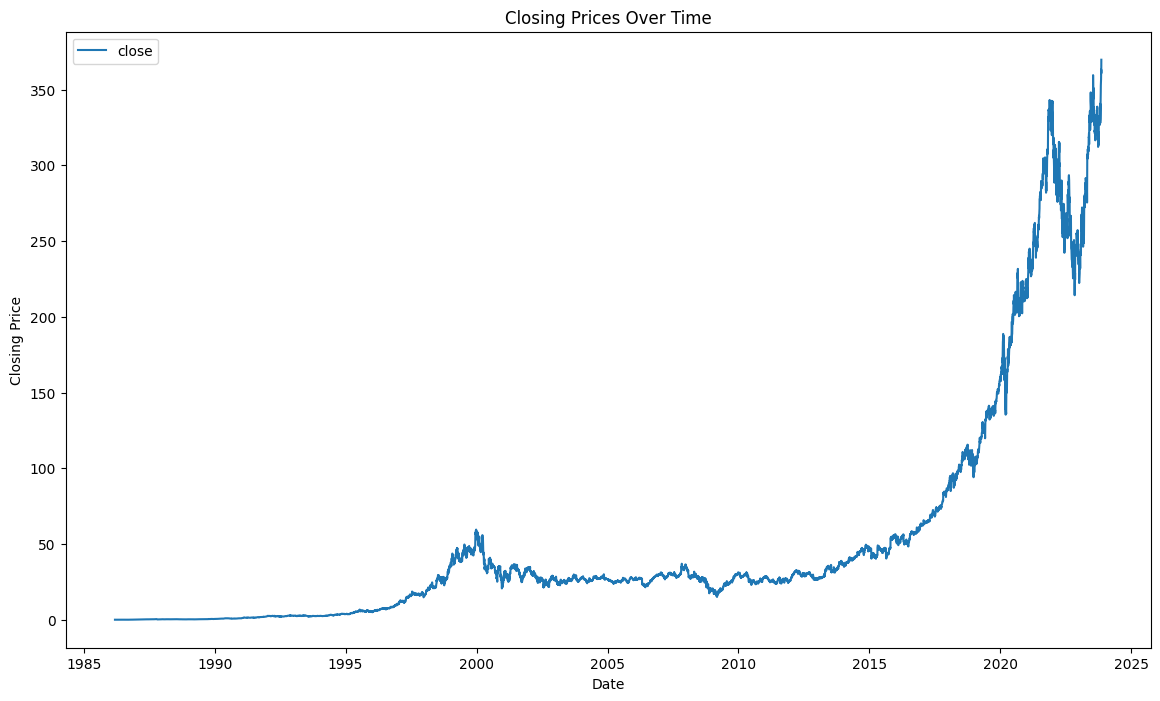

In [8]:
# Time Series Plot (Assuming you have a 'date' column)
time_series_data = stockData.select("date", "close").toPandas()
time_series_data.set_index("date", inplace=True)
time_series_data.plot(figsize=(14, 8))
plt.title("Closing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.show()

In [9]:
# Missing Values
missing_values = stockData.select([func.sum(func.col(c).isNull().cast("int")).alias(c + '_missing') for c in stockData.columns]).collect()

print("Missing Values:")
for row in missing_values[0].asDict():
    print(f"{row}: {missing_values[0][row]}")


Missing Values:
date_missing: 0
low_missing: 0
open_missing: 0
high_missing: 0
volume_missing: 0
close_missing: 0


In [10]:
# Filter rows where 'volume' is missing
missing_volume_rows = stockData.filter(stockData['volume'].isNull())

# Show the missing values
missing_volume_rows.show()


+----+---+----+----+------+-----+
|date|low|open|high|volume|close|
+----+---+----+----+------+-----+
+----+---+----+----+------+-----+



In [11]:
# Fill missing values in the 'volume' column with 0
stockData = stockData.na.fill(0, subset=['volume'])

# Show the DataFrame after filling missing values
stockData.show()


+----------+--------+--------+--------+----------+--------+
|      date|     low|    open|    high|    volume|   close|
+----------+--------+--------+--------+----------+--------+
|1986-03-13|0.088542|0.088542|0.101563|1031788800|0.097222|
|1986-03-13|0.088542|0.088542|0.101563|1031788800|0.097222|
|1986-03-13|0.088542|0.088542|0.101563|1031788800|0.097222|
|1986-03-14|0.097222|0.097222|0.102431| 308160000|0.100694|
|1986-03-14|0.097222|0.097222|0.102431| 308160000|0.100694|
|1986-03-14|0.097222|0.097222|0.102431| 308160000|0.100694|
|1986-03-17|0.100694|0.100694|0.103299| 133171200|0.102431|
|1986-03-17|0.100694|0.100694|0.103299| 133171200|0.102431|
|1986-03-17|0.100694|0.100694|0.103299| 133171200|0.102431|
|1986-03-18|0.098958|0.102431|0.103299|  67766400|0.099826|
|1986-03-18|0.098958|0.102431|0.103299|  67766400|0.099826|
|1986-03-18|0.098958|0.102431|0.103299|  67766400|0.099826|
|1986-03-19|0.097222|0.099826|0.100694|  47894400| 0.09809|
|1986-03-19|0.097222|0.099826|0.100694| 

In [12]:
# Check for duplicate values in the 'date' column
duplicate_rows = stockData.groupBy('date', 'close').count().filter('count > 1')

# Show the duplicate dates and close prices, if any
if duplicate_rows.count() > 0:
    print("Duplicate dates and close prices found:")
    duplicate_rows.show()
else:
    print("No duplicate dates and close prices found.")

Duplicate dates and close prices found:
+----------+--------+-----+
|      date|   close|count|
+----------+--------+-----+
|1986-11-14|0.147569|    3|
|1987-05-15|0.414063|    3|
|1988-08-11|0.359375|    3|
|1988-08-22|0.333333|    3|
|1988-09-19|0.359375|    3|
|1989-02-06|0.420139|    3|
|1989-09-14|0.442708|    3|
|1989-11-14|0.600694|    3|
|1990-01-23|0.623264|    3|
|1990-06-01|1.043403|    3|
|1991-01-14|1.065972|    3|
|1991-03-20|   1.375|    3|
|1991-06-21|1.420139|    3|
|1992-03-02|  2.5625|    3|
|1992-09-15|2.539063|    3|
|1993-06-11|2.792969|    3|
|1993-08-06|2.289063|    3|
|1994-01-05|2.570313|    3|
|1996-05-29|7.320313|    3|
|1997-05-13|14.71875|    3|
+----------+--------+-----+
only showing top 20 rows



In [11]:
# Drop duplicate combinations of date and close price, keeping the first occurrence
cleanedStockData = stockData.dropDuplicates(['date', 'close'])

# Check for duplicate values in the 'date' column after cleaning
duplicate_rows = cleanedStockData.groupBy('date').count().filter('count > 1')

# Show the duplicate dates, if any
if duplicate_rows.count() > 0:
    print("Duplicate dates found after cleaning:")
    duplicate_rows.show()
else:
    print("No duplicate dates found after cleaning.")

No duplicate dates found after cleaning.


In [12]:
cleanedStockData.orderBy(func.desc("date")).show()

+----------+-------+------+------+--------+------+
|      date|    low|  open|  high|  volume| close|
+----------+-------+------+------+--------+------+
|2023-11-10| 361.07|361.49|370.09|25133509|369.67|
|2023-11-09|360.362| 362.3|364.79|21186290|360.69|
|2023-11-08| 360.55|361.68|363.87|22943481| 363.2|
|2023-11-07| 357.63| 359.4|362.46|25807100|360.53|
|2023-11-06| 353.35|353.45|357.54|23828300|356.53|
|2023-11-03| 347.33|349.63|354.39|23624000| 352.8|
|2023-11-02| 344.77|347.24|348.83|24348100|348.32|
|2023-11-01| 339.65|339.79|347.42|28158800|346.07|
|2023-10-31| 334.69|338.85| 339.0|20265300|338.11|
|2023-10-30| 331.83|333.41|339.45|22828100|337.31|
|2023-10-27|  328.4|330.43|336.72|29856500|329.81|
|2023-10-26| 326.94|340.54|341.63|37828500|327.89|
|2023-10-25| 337.62|345.02| 346.2|55053800|340.67|
|2023-10-24|  327.6| 331.3|331.84|31153600|330.53|
|2023-10-23| 324.39|325.47|332.73|24374700|329.32|
|2023-10-20| 325.45|331.72|331.92|25012600|326.67|
|2023-10-19| 330.91|332.15|336.

In [13]:
# minus 1 cuz of o-based index
short_term_date = 4
intermediate_term_date = 19
long_term_date = 199
fifty_day_date = 49
round_to_decimal = 2

# Define the window specifications for different moving averages
short_term_window = Window().orderBy(func.desc("date")).rowsBetween(0, short_term_date)
intermediate_term_window = Window().orderBy(func.desc("date")).rowsBetween(0, intermediate_term_date)
fifty_day_window = Window().orderBy(func.desc("date")).rowsBetween(0, fifty_day_date)
long_term_window = Window().orderBy(func.desc("date")).rowsBetween(0, long_term_date)


# Calculate moving averages for each window
cleanedStockData = cleanedStockData.withColumn("5_days_sma", func.round(func.avg("close").over(short_term_window), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("20_days_sma", func.round(func.avg("close").over(intermediate_term_window), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("50_days_sma", func.round(func.avg("close").over(fifty_day_window), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("200_days_sma", func.round(func.avg("close").over(long_term_window), round_to_decimal))

# Assuming 'cleanedStockData' is your DataFrame
bottom_200_rows = cleanedStockData.select(['date','close',"5_days_sma","20_days_sma", \
                                           "50_days_sma", "200_days_sma"]) \
                                            .orderBy(func.desc("date")).limit(200)

# Show the bottom 200 rows
bottom_200_rows.show()

23/11/13 17:07:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 17:07:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 17:07:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 17:07:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 17:07:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 17:07:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 1

+----------+------+----------+-----------+-----------+------------+
|      date| close|5_days_sma|20_days_sma|50_days_sma|200_days_sma|
+----------+------+----------+-----------+-----------+------------+
|2023-11-10|369.67|    362.12|     342.21|     332.31|      310.76|
|2023-11-09|360.69|    358.75|     340.12|     331.47|      310.15|
|2023-11-08| 363.2|    356.28|     338.64|     330.83|      309.55|
|2023-11-07|360.53|    352.85|      337.1|     330.14|      308.94|
|2023-11-06|356.53|    348.37|     335.49|      329.4|      308.35|
|2023-11-03| 352.8|    344.52|     334.16|     328.73|      307.77|
|2023-11-02|348.32|    339.92|     332.88|     328.07|      307.17|
|2023-11-01|346.07|    335.84|     331.43|     327.65|      306.61|
|2023-10-31|338.11|    334.76|     330.08|     327.17|      306.08|
|2023-10-30|337.31|    333.24|     328.84|     326.85|      305.58|
|2023-10-27|329.81|    331.64|     328.07|     326.43|      305.09|
|2023-10-26|327.89|    331.02|     327.36|     3

In [16]:
#  Bollinger Bands with SMAs
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

round_to_decimal = 2

# Assuming you have a SparkSession named spark and your DataFrame is named cleanedStockData
intermediate_term_date = 20

# Define the window specification
bollinger_window = Window().orderBy(F.desc("date")).rowsBetween(0, intermediate_term_date - 1)  # Adjust the window size as needed

# Calculate the 20-day simple moving average (SMA)
cleanedStockData = cleanedStockData.withColumn("20_days_sma", F.round(F.avg("close").over(bollinger_window), round_to_decimal))

# Calculate the standard deviation of the close prices over the same window
cleanedStockData = cleanedStockData.withColumn("20_days_stddev", F.round(F.stddev("close").over(bollinger_window), round_to_decimal))

# Calculate the upper and lower Bollinger Bands
cleanedStockData = cleanedStockData.withColumn("upper_band", F.round(F.col("20_days_sma") + 2 * F.col("20_days_stddev"), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("lower_band", F.round(F.col("20_days_sma") - 2 * F.col("20_days_stddev"), round_to_decimal))

# Show the resulting DataFrame
cleanedStockData.select("date", "close", "20_days_sma", "upper_band", "lower_band").show()


23/11/12 21:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 2

+----------+------+-----------+----------+----------+
|      date| close|20_days_sma|upper_band|lower_band|
+----------+------+-----------+----------+----------+
|2023-11-10|369.67|     342.21|    369.91|    314.51|
|2023-11-09|360.69|     340.12|    365.32|    314.92|
|2023-11-08| 363.2|     338.64|    362.16|    315.12|
|2023-11-07|360.53|      337.1|     357.7|     316.5|
|2023-11-06|356.53|     335.49|    353.21|    317.77|
|2023-11-03| 352.8|     334.16|     349.0|    319.32|
|2023-11-02|348.32|     332.88|    345.12|    320.64|
|2023-11-01|346.07|     331.43|    342.81|    320.05|
|2023-10-31|338.11|     330.08|    340.54|    319.62|
|2023-10-30|337.31|     328.84|     341.0|    316.68|
|2023-10-27|329.81|     328.07|    339.93|    316.21|
|2023-10-26|327.89|     327.36|     340.4|    314.32|
|2023-10-25|340.67|     326.65|    341.05|    312.25|
|2023-10-24|330.53|     325.26|    339.34|    311.18|
|2023-10-23|329.32|     324.34|    339.34|    309.34|
|2023-10-20|326.67|     323.

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.window import Window

# Updated function to calculate exponential moving average
def calculate_ema(data, alpha):
    ema = data[0]  # Set the initial value as the first data point
    for i in range(1, len(data)):
        ema = alpha * data[i] + (1 - alpha) * ema
    
    return ema

# Convert the calculate_ema_udf function to a Spark UDF
calculate_ema_udf = func.udf(lambda data, alpha: float(calculate_ema(data, alpha)), FloatType())

# Define the periods and alpha values
short_term_period = 5
intermediate_term_period = 20
fifty_day_period = 50
long_term_period = 200
alpha_short = 2 / (short_term_period + 1)
alpha_intermediate = 2 / (intermediate_term_period + 1)
alpha_fifty = 2 / (fifty_day_period + 1)
alpha_long = 2 / (long_term_period + 1)

round_to_decimal = 2

# Apply the UDF to calculate EMAs
cleanedStockData = cleanedStockData.withColumn("5_days_ema", func.round(calculate_ema_udf(func.collect_list("close"). \
                                                                               over(Window().orderBy(func.desc("date")). \
                                                                                    rowsBetween(0, short_term_period - 1)), func.lit(alpha_short)), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("20_days_ema", func.round(calculate_ema_udf(func.collect_list("close").over(Window().orderBy(func.desc("date")). \
                                                                                                                rowsBetween(0, intermediate_term_period - 1)), func.lit(alpha_intermediate)), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("50_days_ema", func.round(calculate_ema_udf(func.collect_list("close").over(Window().orderBy(func.desc("date")). \
                                                                                                                rowsBetween(0, fifty_day_period - 1)), func.lit(alpha_fifty)), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("200_days_ema", func.round(calculate_ema_udf(func.collect_list("close").over(Window().orderBy(func.desc("date")). \
                                                                                                                 rowsBetween(0, long_term_period - 1)), func.lit(alpha_long)), round_to_decimal))

# Show the result
cleanedStockData.select(['date', 'close', '5_days_ema', '20_days_ema', '50_days_ema', '200_days_ema']).orderBy(func.desc("date")).show()



23/11/12 21:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 2

+----------+------+----------+-----------+-----------+------------+
|      date| close|5_days_ema|20_days_ema|50_days_ema|200_days_ema|
+----------+------+----------+-----------+-----------+------------+
|2023-11-10|369.67|    361.41|     340.83|     334.83|      305.21|
|2023-11-09|360.69|    357.36|     338.37|     333.34|      303.42|
|2023-11-08| 363.2|    354.68|     338.02|      333.5|      303.14|
|2023-11-07|360.53|    351.46|     337.13|     332.94|      302.17|
|2023-11-06|356.53|    346.48|     335.75|     332.04|      301.03|
|2023-11-03| 352.8|    342.93|     334.68|     331.18|      299.92|
|2023-11-02|348.32|    337.97|     333.37|     330.13|      298.64|
|2023-11-01|346.07|    334.31|     331.73|      329.7|      297.71|
|2023-10-31|338.11|    335.38|     329.44|     328.34|      296.06|
|2023-10-30|337.31|    333.66|     327.81|     327.98|      295.39|
|2023-10-27|329.81|    331.23|     326.22|     326.52|      293.81|
|2023-10-26|327.89|    329.45|     324.96|     3

In [18]:
#  Bollinger Bands with EMAs
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Updated function to calculate exponential moving average
def calculate_ema(data, alpha):
    ema = data[0]  # Set the initial value as the first data point
    for i in range(1, len(data)):
        ema = alpha * data[i] + (1 - alpha) * ema
    
    return ema

# Convert the calculate_ema_udf function to a Spark UDF
calculate_ema_udf = F.udf(lambda data, alpha: float(calculate_ema(data, alpha)), FloatType())


round_to_decimal = 2

# Assuming you have a SparkSession named spark and your DataFrame is named cleanedStockData
intermediate_term_date = 20

# alpha value for 20 days
alpha_intermediate = 2 / (intermediate_term_period + 1)

# Define the window specification
bollinger_window = Window().orderBy(F.desc("date")).rowsBetween(0, intermediate_term_date - 1)  # Adjust the window size as needed

# Calculate the 20-day Exponential moving average (SMA)
cleanedStockData = cleanedStockData.withColumn("20_days_ema", F.round(calculate_ema_udf(F.collect_list("close").over(Window().orderBy(F.desc("date")). \
                                                                                                                rowsBetween(0, intermediate_term_period - 1)), func.lit(alpha_intermediate)), round_to_decimal))

# Calculate the standard deviation of the close prices over the same window
cleanedStockData = cleanedStockData.withColumn("20_days_stddev", F.round(F.stddev("close").over(bollinger_window), round_to_decimal))

# Calculate the upper and lower Bollinger Bands
cleanedStockData = cleanedStockData.withColumn("upper_band", F.round(F.col("20_days_ema") + 2 * F.col("20_days_stddev"), round_to_decimal))
cleanedStockData = cleanedStockData.withColumn("lower_band", F.round(F.col("20_days_ema") - 2 * F.col("20_days_stddev"), round_to_decimal))

# Show the resulting DataFrame
cleanedStockData.select("date", "close", "20_days_ema", "upper_band", "lower_band").show()


23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 2

+----------+------+-----------+----------+----------+
|      date| close|20_days_ema|upper_band|lower_band|
+----------+------+-----------+----------+----------+
|2023-11-10|369.67|     340.83|    368.53|    313.13|
|2023-11-09|360.69|     338.37|    363.57|    313.17|
|2023-11-08| 363.2|     338.02|    361.54|     314.5|
|2023-11-07|360.53|     337.13|    357.73|    316.53|
|2023-11-06|356.53|     335.75|    353.47|    318.03|
|2023-11-03| 352.8|     334.68|    349.52|    319.84|
|2023-11-02|348.32|     333.37|    345.61|    321.13|
|2023-11-01|346.07|     331.73|    343.11|    320.35|
|2023-10-31|338.11|     329.44|     339.9|    318.98|
|2023-10-30|337.31|     327.81|    339.97|    315.65|
|2023-10-27|329.81|     326.22|    338.08|    314.36|
|2023-10-26|327.89|     324.96|     338.0|    311.92|
|2023-10-25|340.67|     325.61|    340.01|    311.21|
|2023-10-24|330.53|     323.02|     337.1|    308.94|
|2023-10-23|329.32|     321.82|    336.82|    306.82|
|2023-10-20|326.67|     321.

23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/12 21:57:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [25]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming cleanedStockData is your DataFrame
# Add a unique identifier column "ID"
cleanedStockData = cleanedStockData.withColumn("ID", F.monotonically_increasing_id())

# Define the window specification
partition_cols = ["ID"]
rsi_window = Window().partitionBy(partition_cols).orderBy(F.desc("date")).rowsBetween(0, 13)  # Assuming a 14-day RSI, adjust as needed

# Calculate lag without window specification
cleanedStockData = cleanedStockData.withColumn("lag_close", F.lag("close").over(Window().orderBy("ID")))
cleanedStockData = cleanedStockData.withColumn("price_change", F.when(F.isnull(F.col("lag_close")), 0).otherwise(F.col("close") - F.col("lag_close")))

# Calculate the daily gains and losses
gains = F.when(F.col("price_change") > 0, F.col("price_change")).otherwise(0)
losses = F.when(F.col("price_change") < 0, F.abs(F.col("price_change"))).otherwise(0)

# Calculate the average gains and losses over the window
avg_gains = F.avg(gains).over(rsi_window)
avg_losses = F.avg(losses).over(rsi_window)

# Calculate the relative strength (RS)
rs = avg_gains / avg_losses

# Calculate the RSI
rsi = 100 - (100 / (1 + rs))

# Add the RSI column to the DataFrame
cleanedStockData = cleanedStockData.withColumn("rsi_14", F.when(F.isnull(rsi), 0).otherwise(rsi))

# Filter for the latest 200 days
latest_200_days = cleanedStockData.orderBy(F.desc("date")).limit(200)

# Show the resulting DataFrame
latest_200_days.select("ID", "date", "close", "rsi_14").show()


23/11/13 16:17:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 16:17:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 16:17:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 16:17:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----+----------+------+------+
|  ID|      date| close|rsi_14|
+----+----------+------+------+
|7086|2023-11-10|369.67|   0.0|
|7046|2023-11-09|360.69|   0.0|
|1561|2023-11-08| 363.2|   0.0|
| 825|2023-11-07|360.53|   0.0|
|6801|2023-11-06|356.53|   0.0|
|1699|2023-11-03| 352.8|   0.0|
|7414|2023-11-02|348.32|   0.0|
|7671|2023-11-01|346.07|   0.0|
|7506|2023-10-31|338.11|   0.0|
|3240|2023-10-30|337.31|   0.0|
|8871|2023-10-27|329.81|   0.0|
|8313|2023-10-26|327.89|   0.0|
|3466|2023-10-25|340.67|   0.0|
|1009|2023-10-24|330.53|   0.0|
| 477|2023-10-23|329.32|   0.0|
|2477|2023-10-20|326.67|   0.0|
|1787|2023-10-19|331.32|   0.0|
|2628|2023-10-18|330.11|   0.0|
|8143|2023-10-17|332.06|   0.0|
|7635|2023-10-16|332.64|   0.0|
+----+----------+------+------+
only showing top 20 rows



23/11/13 16:17:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/13 16:17:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
